<a href="https://colab.research.google.com/github/edwingarcia18/CONVOLUCIONAL/blob/main/Clasificador_de_im%C3%A1genes_con_red_neuronal_convolucional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install git+https://github.com/mert-kurttutan/torchview.git

  Cloning https://github.com/mert-kurttutan/torchview.git to /tmp/pip-req-build-x8g0kexp
  Running command git clone --filter=blob:none --quiet https://github.com/mert-kurttutan/torchview.git /tmp/pip-req-build-x8g0kexp
  Resolved https://github.com/mert-kurttutan/torchview.git to commit c640a4a55e49183fe05a8673f0a6d43943fbe84b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torchview: filename=torchview-0.2.6-py3-none-any.whl size=25413 sha256=1529bd7988adad7e8873aba3f2c2e518a7232484cf3dcb55f685ef981831ce5f
  Stored in directory: /tmp/pip-ephem-wheel-cache-zjr0m0bm/wheels/da/1e/01/dc3f612d3119cde4bff91b0aa192bdf07d67e6a7a981baa686
Successfully built torchview


In [ ]:
# importamos la libreria pytorch
import torch
from torch import nn
from torch import optim #las funciones de optimizacion (gradient descent)
from torch.optim.lr_scheduler import StepLR #learning rate decay
import torch.nn.functional as F #convencion
from torchvision import datasets, transforms
from torchview import draw_graph

# matplotlib para pintar graficas
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# usamos la GPU si esta disponible
if torch.cuda.is_available():
  device = torch.device("cuda")
  print("Dispositivo usado: GPU con CUDA")
else:
  device = torch.device("cpu")
  print("Dispositivo usado: CPU")

Dispositivo usado: GPU con CUDA


In [ ]:
# Definir una transformación para convertir la imagen a un tensor
transform=transforms.Compose([
    transforms.ToTensor(), # hay que convertir a tensor los datos
    transforms.Normalize((0.2860,), (0.3530,)) # normalizacion del dataset
    ])

# Descargar el dataset FashionMNIST de articulos de ropa
dataset_train = datasets.FashionMNIST('data', train=True, download=True, transform=transform)
dataset_test = datasets.FashionMNIST('data', train=False, download=True, transform=transform)

# tamaño del batch
batch_size = 64
train_kwargs = {'batch_size': batch_size}
test_kwargs = {'batch_size': batch_size}

# generamos los dataloaders que se usaran para leer
# las imagenes el entrenamiento y test
train_loader = torch.utils.data.DataLoader(dataset_train,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset_test, **test_kwargs)

# categoria de ropa que corresponde a cada numero
desc = ['Camiseta/top', 'Pantalon', 'Jersey', 'Vestido', 'Abrigo', 'Sandalia', 'Camisa', 'Zapatilla', 'Bolso', 'Bota']

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.1MB/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 168kB/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.21MB/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 5.14MB/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



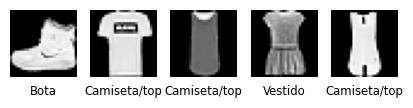

In [ ]:
# primero, vemos unas imagenes del set de entrenamiento con sus etiquetas (labels)
figure = plt.figure(figsize=(5, 1))

# configurar tamaño de texto para las graficas
plt.rc('font', size=7)

for i in range(0,5):
  figure.add_subplot(1, 5, i+1)
  img, label = dataset_train[i]

  # img tiene dimensiones [1,28,28], squeeze() destruye las dimensiones de tamaño 1
  plt.imshow(img.squeeze(), cmap='Greys_r')
  plt.axis('off')
  plt.title(desc[label], y=-0.4)

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.convolucion1 = nn.Conv2d(1, 32, 3, 1)
        self.convolucion2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fcapa1 = nn.Linear(9216, 128)
        self.fcapa2 = nn.Linear(128, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = F.relu(self.convolucion1(x))
        x = F.relu(self.convolucion2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        print(x.size())

        x = torch.flatten(x, 1)
        x = F.relu(self.fcapa1(x))
        x = self.dropout2(x)
        x = self.fcapa2(x)
        output = self.softmax(x)
        return output

torch.Size([64, 64, 12, 12])


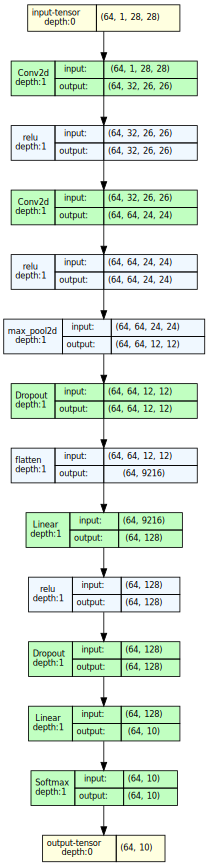

In [ ]:
model = CNN();
model_graph = draw_graph(model, input_size=(batch_size, 1,28,28))
model_graph.visual_graph

torch.Size([1, 64, 12, 12])
torch.Size([1, 64, 12, 12])
torch.Size([1, 64, 12, 12])
torch.Size([1, 64, 12, 12])
torch.Size([1, 64, 12, 12])


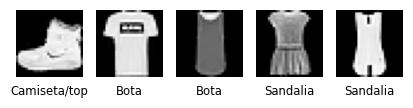

In [ ]:
# Comportamiento de la red neuronal antes de entrenar
torch.manual_seed(50)

model = CNN()

figure = plt.figure(figsize=(5, 1))

for i in range(0,5):

  output = model(dataset_train.data[i].view(1,1,28,28).float()) # broadcast

  # de las diez neuronas de salida, la que tenga
  # mayor valor corresponde a la prediccion del modelo
  pred = output.argmax(dim=1, keepdim=True)

  # graficamos el resultado
  figure.add_subplot(1, 5, i+1)
  plt.axis('off')
  plt.imshow(dataset_train.data[i], cmap='Greys_r')
  plt.title(desc[pred.item()], y=-0.4)

In [ ]:
# Regularización Elastic Net
regularization = "Elastic Net"
l1_weight = 0.00001
l2_weight = 0.0001

In [ ]:
def train(model):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        # mandamos los datos al dispositivo (necesario cuando se usa la GPU)
        data, target = data.to(device), target.to(device)

        # calculamos la salida del modelo (prediccion)
        output = model(data)

        # definimos la funcion de perdida como el error cuadratico medio
        # como la prediccion del modelo es un vector de 10 elementos (las 10 neuronales finales)
        # hay que convertir la label del set de entrenamiento en un vector
        # con el valor correspondiente 1 y todos los demas valores 0 (un vector one-hot)
        target_onehot = F.one_hot(target, num_classes=10).float()
        loss = F.mse_loss(output, target_onehot)

       # se suman los terminos de regularizacion si esta activada
        if regularization == "L1 (Lasso)" or regularization == "Elastic Net":
            l1_term = l1_weight * sum([p.abs().sum() for p in model.parameters()])
            # se escala para que las graficas del loss al final sean comparables
            l1_term /= 10
            loss += l1_term
        if regularization == "L2 (Ridge)" or regularization == "Elastic Net":
            l2_term = l2_weight * sum([(p**2).sum() for p in model.parameters()])
            # se escala para que las graficas del loss al final sean comparables
            l2_term /= 10
            loss += l2_term

        # se ejecuta el backpropagation para calcular el gradiente
        loss.backward()

        # se guarda el historico de la perdida para graficarlo
        loss_training.append(loss.item())

        # se actualizan los pesos y sesgos de la red
        optimizer.step()

        # se resetean a cero los gradientes
        optimizer.zero_grad()
        print_interval = 50
        if batch_idx % print_interval == 0:
            print('   Loss: ', loss.item())

    print('Training Epoch completado\n')

In [ ]:
def test(model, split):
    if split == 'train':
        loader = train_loader
        loss_history = loss_train_split
    else:
        loader = test_loader
        loss_history = loss_test_split

    model.eval()

    # lista para almacenar los fallos,
    # global para que se pueda consultar fuera de la funcion
    global errorList
    errorList = []
    correct = 0
    test_loss = 0

    # durante el test solo hacemos el forward pass y no necesitamos los gradientes
    with torch.no_grad():
        for data, target in loader:

            # mandamos los datos al dispositivo (necesario cuando se usa la GPU)
            data, target = data.to(device), target.to(device)

            # calculamos la salida del modelo (prediccion)
            output = model(data)
            target_onehot = F.one_hot(target, num_classes=10).float()

            # suma acumulada de la pérdida
            test_loss += F.mse_loss(output, target_onehot, reduction='sum')

            # se suman los terminos de regularizacion si esta activada
            if regularization == "L1 (Lasso)" or regularization == "Elastic Net":
                l1_term = l1_weight * sum([p.abs().sum() for p in model.parameters()])
                # se escala para que las graficas del loss al final sean comparables
                l1_term *= data.size(0)
                test_loss += l1_term
            if regularization == "L2 (Ridge)" or regularization == "Elastic Net":
                l2_term = l2_weight * sum([(p**2).sum() for p in model.parameters()])
                # se escala para que las graficas del loss al final sean comparables
                l2_term *= data.size(0)
                test_loss += l2_term

            # de las diez neuronas de salida, la que tenga
            # mayor valor corresponde a la prediccion del modelo
            pred = output.argmax(dim=1, keepdim=True)

            # si la prediccion es igual al valor etiquetado, se cuenta como correcto
            correct += pred.eq(target.view_as(pred)).sum().item()

            # los que no sean iguales al valor etiquetado,
            # se meten en un array de errores
            for index, error in enumerate(pred.ne(target.view_as(pred))):
              if (error):
                errorList.append({
                    "data": data[index],
                    "pred": pred[index],
                    "target": target[index]
                    })
    test_loss /= len(loader.dataset)*10

    # se guarda el historico de la perdida en el test para graficarlo
    loss_history.append(test_loss.item())

    # imprimir por pantalla los resultados del test
    print('Test (split ', split,
          '):\n   Loss medio: ', test_loss.item(),
          'Errores: ',  len(errorList),
          'Precision: ', 100 * correct / len(loader.dataset), '%\n')


In [ ]:
# ejecutamos un test antes de empezar el entrenamiento
# la precision debe ser sobre el 10% (como hay 10 etiquetas,
# 1 de cada 10 el modelo acertara)
model = CNN()
model.to(device)
loss_test_split = []
test(model, 'test')

torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 12, 12])
torch.Size([64

In [ ]:
# Bucle de entrenamiento de la red

# semilla del generador de numeros aleatorios
# para conseguir resultados deterministas
torch.manual_seed(50)

# lista para graficar la perdida de entrenamiento y test
loss_training = []
loss_test_split = []
loss_train_split = []

# Crear una instancia del modelo y pasarla al dispositivo
model = CNN()
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.9)

# learning rate decay, se multiplica por gamma cada step_size steps
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

epochs = 10
for epoch in range(0, epochs):
    print('Epoch:', epoch, 'LR:', scheduler.get_last_lr())
    train(model)
    test(model, 'test')
    test(model, 'train')
    scheduler.step()


Se truncaron las últimas líneas 5000 del resultado de transmisión.
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 12, 12])
torch

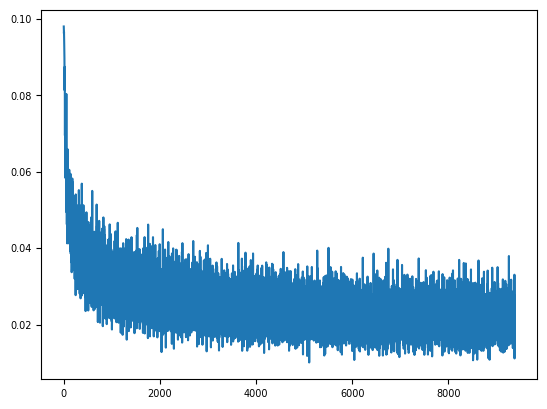

In [ ]:
# graficamos la perdida durante el entrenamiento
plt.plot(loss_training)

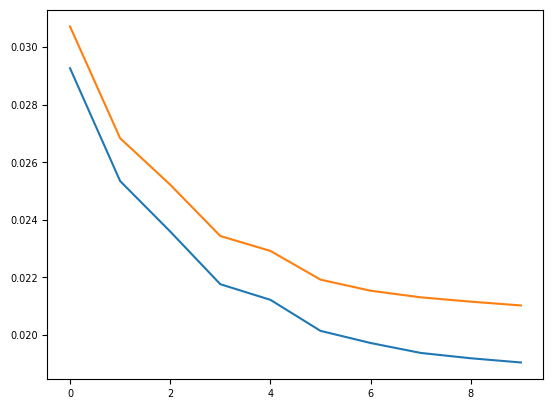

In [ ]:
# graficamos la perdida del split entero de train vs. test
# para ver como de bien generaliza el modelo
plt.plot(loss_train_split)
plt.plot(loss_test_split)

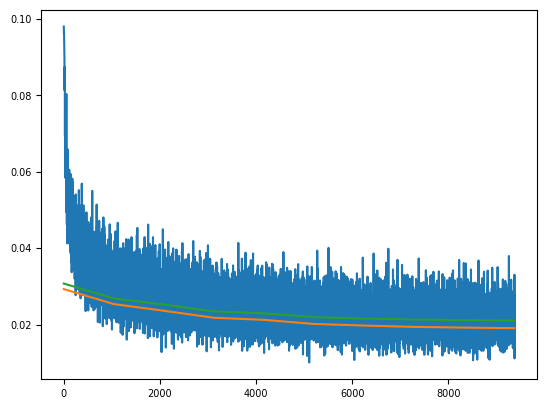

In [ ]:
# comparar la perdida durante el entrenamiento y la de los splits enteros
plt.plot(loss_training)
x = torch.linspace(0, epochs*len(train_loader.dataset)/batch_size, epochs)
plt.plot(x,loss_train_split)
plt.plot(x,loss_test_split)

torch.Size([1, 64, 12, 12])
torch.Size([1, 64, 12, 12])
torch.Size([1, 64, 12, 12])
torch.Size([1, 64, 12, 12])
torch.Size([1, 64, 12, 12])
torch.Size([1, 64, 12, 12])


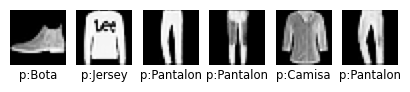

In [ ]:
# pintamos algunas predicciones
figure = plt.figure(figsize=(5, 1))

# cargamos las imagenes del loader
data, target = next(iter(test_loader))
model.eval()
model.zero_grad()

with torch.no_grad():
  for i in range(0,6):

    # calcula la salida del modelo con los parametros entrenados
    input = data[i].view(1,1,28,28).float().to(device)
    output = model(input)
    # mayor valor corresponde a la prediccion del modelo
    pred = output.argmax(dim=1, keepdim=True)

    # pintamos la imagen y la prediccion del modelo
    figure.add_subplot(1, 6, i+1)
    plt.axis('off')
    plt.imshow(data[i].view(28,28), cmap='Greys_r')
    plt.title("p:" + desc[pred.item()], y=-0.4)

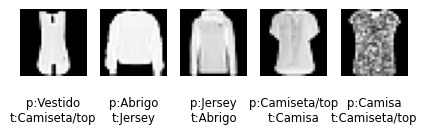

In [ ]:
# pintamos algunas de las predicciones incorrectas
figure = plt.figure(figsize=(5, 1))

for i in range(0,5):
  figure.add_subplot(1, 5, i+1)
  plt.axis('off')
  plt.imshow(errorList[i]["data"].view(28,28).cpu(), cmap='Greys_r')
  plt.title(
      "p:" + desc[errorList[i]["pred"].item()] +  #prediccion
      "\nt:" + desc[errorList[i]["target"].item()],  #target
      y=-0.8)